In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functools
import glob
import os
import pickle
import subprocess
import re

# Part II - Reinforcement Learning

In the second task we implemented a Reinforcement Learning (RL) methodology for the same problem which is play the Ms. Pacman game. 

## About the RL

The two main elements for the RL are the agent and the environment; The agent does actions that interacts with the environment, and the latter produces rewards and a new state for the agent. Given this scenario, our goal is to find the agent that learns the sequence of actions the results in the maxium reward. 


Therefore the RL problem is modeled as a Markovian decision process (MDP), such that the agents decision (i.e., action) at some time point $t$ depends only from the agent's state at the same time point $t$. Therefore, for each time point $t = 0, 1, 2, ...$ the agent will be in a state $s_t$ from a set $S$ for a time $t$. For each state the agent can chose an action $a_t$ from an action set $A(s_t)$, receiving an reward $r_{t+1}$ from environment after its execution, and moving to the next state $s_{t+1}$. Furthermore, the reward and next states follows a probability mass function $p(r_{t+1} | s_t, a_t)$ and $p(s_{t+1} | s_t, a_t)$, and for a deterministic problem a single value is used instead of a probabilistic distribution.

## Modeling

### MDP and Q-Learning

For the Pacman problem the MDP modeling resumes to:

- States: All possible configuration (i.e. pacman, ghost, foods and capsules positions);
- Actions: A finite number of actions: {North, South, West, East, Stop};
- Rewards: A real number for each combination of state and action;
- Policy:  A Map from states to actions.

We do not use the scores as rewards, instead we used a custom set of Rewards:


|   Value  |    Motive     |
|----------|:-------------:|
| -1000    |  Lose                             |
| 500      |  Win                              |
| -5       |  Single stop                      |
| -10      |  Two consecutives stop            |
| -1       |  Single Non-stop action           |
| -3       |  Two consecutives non-stop action |
| 5        |  Eats a food                      |
| 50       |  Eats a ghost                     |
| 1        |  Eats a capsule                   |

Then the goal is to finish the game with the maximum possible reward, in this way the $Q$ values are calculated as a expected reward for each pair state-action, and since the Pacman problem is deterministic, those $Q$ values are obtained from 

$Q(s_t, a_t) = r_{r+1} + \gamma max Q(s_{t+1}, a_{t+1})$,
    

and for the algorithm, after receive a reward $r_{t+1}$ the Q value is update by

$\hat{Q} (s_t, a_t) \gets Q (s_t, a_t) + \eta ( r_{t+1} + \gamma max \hat{Q}(s_{t+1}, a_{t+1}) - Q ((s_t, a_t) )$


This is the equation of the Q-Learning algorithm, with the discont factor $\gamma$ and the learning rate $\eta$ [5]. The Q-Learning algorithm is a free-model and off-policy algorithm; Free-model since the $p(r_{t+1} | s_t, a_t)$ and $p(s_{t+1} | s_t, a_t)$ are not necessary and off-policy once that we use the max value of $Q$ instead of a well-established policy $\pi: a_t \gets s_t$.


### Function approximation

Notice that the above definitions requires a register for all $Q(s,a)$, and presenting the whole layout as  matrix of states is unfeaseble due to the number of states and actions as the computation progresses. Take the Pacman problem with the *small* layout for example. This layout has 64 positions, therefore the number of possible combinations of states is far greater than 262 thousand for the pacman and ghosts, without the foods and capsules states.

A solution is to use a small number of features and a function approximation to describe the quality of the state; Furthermore, from a $f(s,a)$ features vector and given $w_t$ weights vector, now the Q value of each state is measured as 

$Q(s,a) = {w_t}^{T} \; \phi[s,a]$
 
with the update term is defined as follow:

$\delta \gets r_{t+1} + \gamma \cdot max_{a'} Q(s',a') - Q(s,a)$

$w_{t+1} \gets w_{t} + \eta \cdot \delta \cdot \phi[s,a]$ .


as described in [6]. Where the vector $\phi[s,a]$ is likely $[f_0(s,a), f_1(s,a), .., f_n(s,a)]$, with the bias $f_n(s,a)$ constant. And for the convergence a restrition of $| \phi[s,a]| < 1$ is taken [7].

We first tried using the same features as the previous task, but the agents were not very successful. Hence, we used the following features, some of them were proposed in [8]:

- Distance to closest food;
- Activate boolean feature if has a ghost nearby (2 steps);
- Distance to closest ghost;
- Inverse distance to closest ghost;
- Distance to the closes scared ghost;
- Activate boolean feature if has a scared ghost nearby (2 steps);
- Distance to closest capsule;
- Activate boolean feature if has a capsule closer than a ghost (3 steps);
- Activate boolean feature if has a food nearby and do not has a ghost nearby.

The implementation of the RL agent can be found on the `rlAgents.py` file.

## Defining functions for the report

In [10]:
def moving_average(data_set, periods=50):
    weights = np.ones(periods) / periods
    return np.convolve(data_set, weights, mode='valid')


def subplotcurves(c_ax, values, keys, g_i):
    c_ax.plot(moving_average( values[0][ keys ]))
    c_ax.plot(moving_average( values[1][ keys ]))
    c_ax.plot(moving_average( values[2][ keys ]))
    c_ax.plot(moving_average( values[3][ keys ]))
    c_ax.plot(moving_average( values[4][ keys ]))
    c_ax.legend(
              (str(g_i[0]), str(g_i[1]), str(g_i[2]), str(g_i[3]), str(g_i[4])),
              loc='lower right', shadow=True)
    c_ax.set_xlabel('Episodes')
    c_ax.set_ylabel(keys)
    

def readRLPickle(layout, number):
    filepath = 'rl-exps-egreedy/' + layout + '_logs' + str(number) + '.pickle'
    with open(filepath, 'rb') as handle:
        loaddata = pickle.load(handle)
    
    return loaddata
    
def plotRLData(data):
    best_indexes = data.sort_values('win rate', ascending=False)[0:5].index
    worst_indexes = data.sort_values('win rate')[0:5].index
    #list
    b_list = []
    w_list = []
    fig, axs = plt.subplots(2,2, figsize=(15,15))
    for i,w in zip(best_indexes, worst_indexes):
        #load pickle
        tdict = readRLPickle('smallClassic', i)
        b_list.append(tdict)
        tdict = readRLPickle('smallClassic', w)
        w_list.append(tdict)

    subplotcurves(axs[0][0], b_list, 'reward', best_indexes)
    axs[0][0].set_title('Reward vs episodes for best runs')


    subplotcurves(axs[0][1], w_list, 'reward', worst_indexes)
    axs[0][1].set_title('Reward vs episodes for worst runs')

    subplotcurves(axs[1][0], b_list, 'actions', best_indexes)
    axs[1][0].set_title('N. Actions vs episodes for best runs')

    subplotcurves(axs[1][1], w_list, 'actions', worst_indexes)
    axs[1][1].set_title('N. Actions vs episodes for worst runs')
    

## Usage

### Simple example

The following command executes a new trainning for the small layout for 500 games, using a discount factor of 0.9 and a learning rate of 0.001. The commands also does a 10 games test. (The `rlMain.py` script calls internally the `pacman.py` with the *rlAgent*, for more see the `rlAgents.py`)

In [11]:
!python rlMain.py -r True -l smallClassic -ng 500 -df 0.9 -lr 0.01

Training done with avgScore 836.064 avgActions 99.476 avgWR 0.7
Testing performance with avgScore 1008.8 avgActions 87.2 avgWR 0.8


The training has a win rate of 70% with average score and number of actions of 836.064 and 99.476 actions. 

In the test, after trained, it archieves a 80% win rate with average score of 1008.8 and average of 87.2 actions. 

While the score and win rate is a little bit lower than the GP agent, the number of actions is significantly smaller.

### Comparative results

Due to the amount o time spent on each run, which increases with the training, the following results were not executed through this jupyter notebook, they were computed with the script `rlExperiments.py`. This script runs 27 configurations of number of games, discount factor and learning rate, saving the results of each training/testing in a *.pickle* file and saving the overall statistics in a *.csv* file.

## Results

### smallClassic layout

In [12]:
#loading csv file
rlSmallData = pd.read_csv('rl-exps-egreedy/smallClassic_data.csv')

The results are ordered according to the best test win rate (`win rate` field): 

In [13]:
rlSmallData.sort_values('win rate', ascending=False)[0:5]

,train actions,train as,train wr,avg. actions,avg. score,win rate,lr,df,ngames
14,106.776667,739.883333,0.64,114.1,1195.9,1.0,0.001,0.6,1500.0
3,94.786000,651.874000,0.57,129.4,1062.6,0.9,0.010,0.6,500.0
16,94.186000,435.524000,0.42,117.8,1088.2,0.9,0.001,0.9,1000.0
6,113.986000,674.014000,0.62,93.9,1063.1,0.9,0.010,0.9,500.0
9,106.916000,491.284000,0.48,132.3,1126.7,0.8,0.001,0.3,500.0


and the worst:

In [14]:
rlSmallData.sort_values('win rate')[0:5]

,train actions,train as,train wr,avg. actions,avg. score,win rate,lr,df,ngames
24,83.846000,-302.026000,0.01,87.3,-331.3,0.0,0.0001,0.9,500.0
21,101.026000,-333.866000,0.02,109.3,-322.3,0.0,0.0001,0.6,500.0
19,79.852000,4.798000,0.16,73.9,306.1,0.2,0.0001,0.3,1000.0
26,79.886667,-199.766667,0.05,77.1,246.9,0.3,0.0001,0.9,1500.0
22,98.136000,-265.366000,0.06,109.2,375.8,0.3,0.0001,0.6,1000.0


The figures above show the smoothed moving average of the reward and the number of actions.

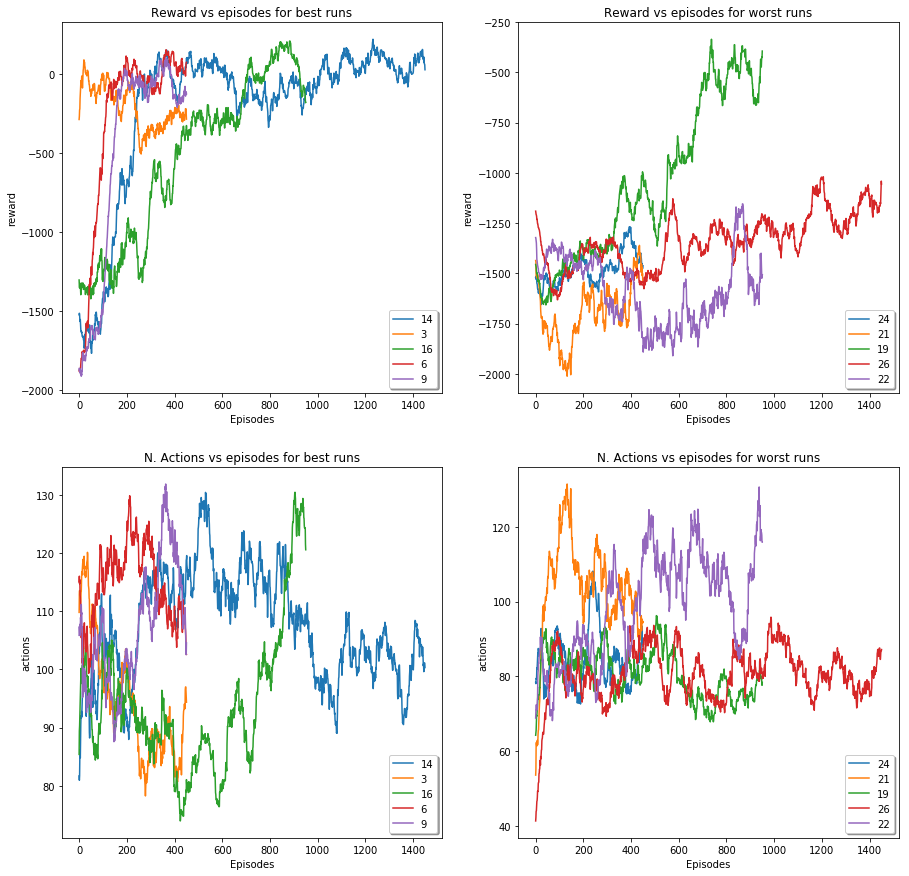

In [15]:
plotRLData(rlSmallData)

From the figures and the data it's clearly how the learning rate affects the results since the worst results has the lowest learning rate (0.0001). Furthermore, the two best results have learning rate of 0.01 and achieves the best results very quickly. Run number 3 has a small negative reward at its beggining, which should be due to the small discount factor (0.6 vs 0.9) and due to the initial random weights $w_0$.

For the number of actions, the results are similar, with a decrease on the number of actions in early episodes for the greater learning rates (runs 3 and 16). However, run 16 shows an increase from the number of actions at the late episodes, showing maybe a divergence due to the greater learning rate value.

### mediumClassic

In [16]:
#loading csv file
rlMediumData = pd.read_csv('rl-exps-egreedy/mediumClassic_data.csv')

In [17]:
rlMediumData.sort_values('win rate', ascending=False)[0:5]

,train actions,train as,train wr,avg. actions,avg. score,win rate,lr,df,ngames
0,166.908000,1227.812000,0.75,201.8,1528.2,1.0,0.010,0.3,500.0
4,163.977000,1225.853000,0.75,165.6,1584.4,1.0,0.010,0.6,1000.0
14,147.146667,1185.460000,0.69,175.3,1514.7,1.0,0.001,0.6,1500.0
11,148.665333,1156.861333,0.69,159.3,1530.7,1.0,0.001,0.3,1500.0
3,155.116000,1133.144000,0.71,171.5,1509.5,0.9,0.010,0.6,500.0


In [18]:
rlMediumData.sort_values('win rate')[0:5]

,train actions,train as,train wr,avg. actions,avg. score,win rate,lr,df,ngames
22,132.650000,-151.740000,0.02,175.2,-237.2,0.0,0.0001,0.6,1000.0
21,141.624000,-285.384000,0.00,114.3,-388.3,0.0,0.0001,0.6,500.0
15,138.180000,15.540000,0.08,120.0,597.0,0.3,0.0010,0.9,500.0
26,135.908667,-155.568667,0.01,185.5,645.5,0.5,0.0001,0.9,1500.0
20,115.210667,734.516000,0.40,178.6,932.4,0.5,0.0001,0.3,1500.0


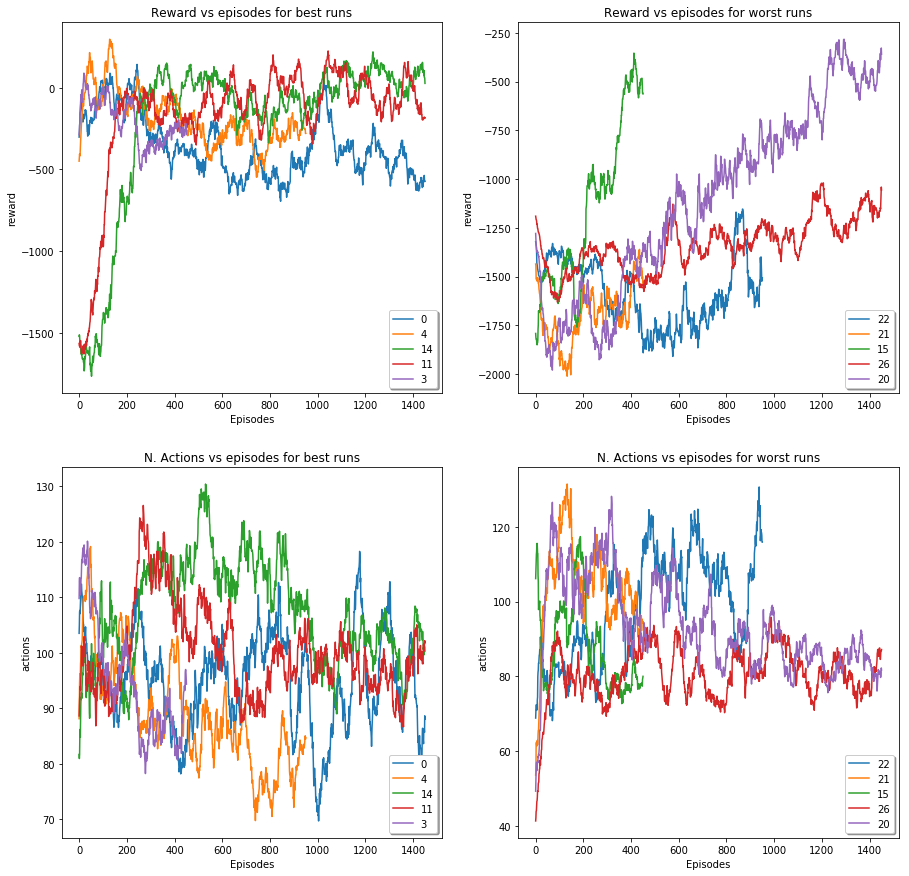

In [19]:
plotRLData(rlMediumData)

As the smallClassic layout, the worst results are obtained from a small learning rate and greater learning rates has a betters results from early episodes.

### originalClassic

In [20]:
rlOriginalData = pd.read_csv('rl-exps-egreedy/originalClassic_data.csv')

In [21]:
rlOriginalData.sort_values('win rate', ascending=False)[0:5]

,train actions,train as,train wr,avg. actions,avg. score,win rate,lr,df,ngames
6,347.316000,1877.244000,0.50,384.3,2345.7,0.8,0.010,0.9,500.0
17,367.037333,1601.302667,0.46,448.1,2307.9,0.7,0.001,0.9,1500.0
16,353.914000,1359.106000,0.38,354.6,2151.4,0.7,0.001,0.9,1000.0
9,332.420000,1629.000000,0.41,325.6,2171.4,0.6,0.001,0.3,500.0
13,326.686000,1680.474000,0.39,356.5,1996.5,0.5,0.001,0.6,1000.0


In [22]:
rlOriginalData.sort_values('win rate')[0:5]

,train actions,train as,train wr,avg. actions,avg. score,win rate,lr,df,ngames
0,385.238,1596.662,0.41,196.4,592.6,0.0,0.0100,0.3,500.0
24,241.516,-373.156,0.00,226.7,-521.7,0.0,0.0001,0.9,500.0
21,237.270,-311.590,0.00,303.5,-194.5,0.0,0.0001,0.6,500.0
18,234.678,-278.418,0.00,326.9,-166.9,0.0,0.0001,0.3,500.0
25,257.629,-278.669,0.00,251.4,-288.4,0.0,0.0001,0.9,1000.0


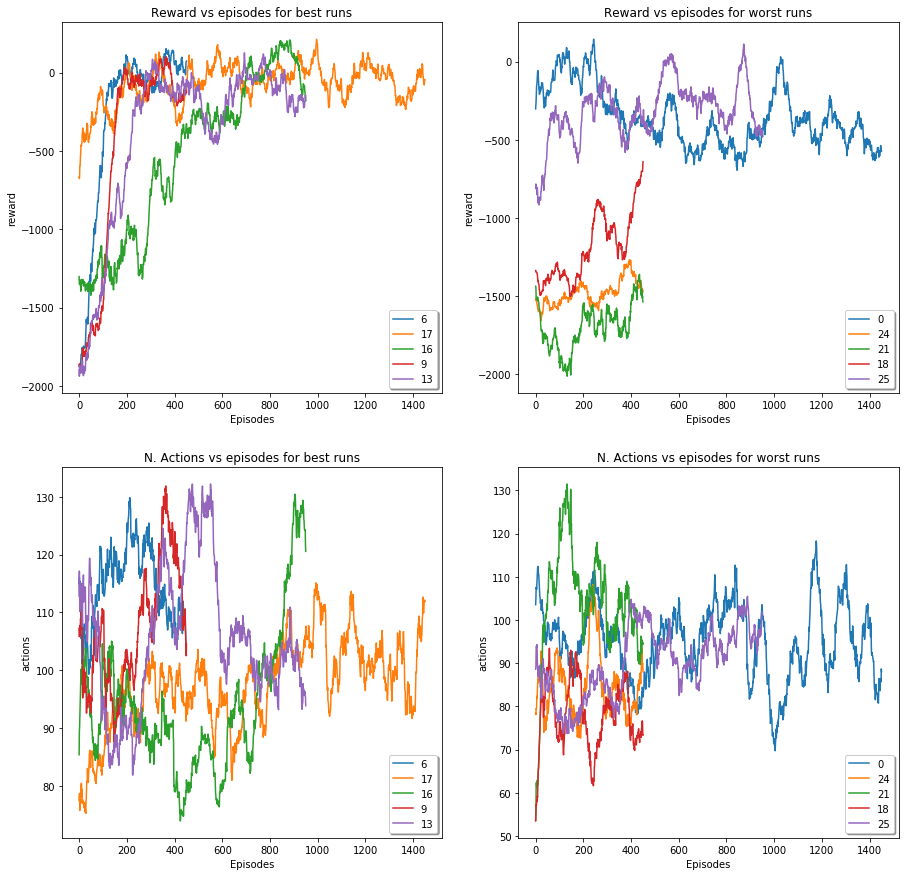

In [23]:
plotRLData(rlOriginalData)

Different from the others layout, the originalClassic layout has a run with learning rate of 0.001 (run '17') with better early results than a learning rate 0.01 (run '6'), which shows the different from initial weights $w_0$.


This layout also highlight the importance of discont factor parameter once the run '6' has the best results and the run '0' has the worst results; Their diffence lies on the discont factor, with the run '6' with a high dicount factor and the run '0' a low discount factor, probabily being a very reactive run.


# References


[5] Alpaydin, Ethem. Machine learning: the new AI. MIT press, 2009.

[6] Szepesvári, Csaba. "Algorithms for reinforcement learning." Synthesis lectures on artificial intelligence and machine learning 4.1 (2010): 1-103.

[7] Melo, Francisco S., and M. Isabel Ribeiro. "Q-learning with linear function approximation." International Conference on Computational Learning Theory. Springer, Berlin, Heidelberg, 2007.

[8] Gnanasekaran, Abeynaya, Jordi Feliu Faba, and Jing An. "Reinforcement Learning in Pacman.", 2017, URL: http://cs229.stanford.edu/proj2017/final-reports/5241109.pdf .